# Entropy estimates in the Hernquist potential

Here we estimate the entropy of samples in the Hernquist potential ([Hernquist 1990](https://ui.adsabs.harvard.edu/abs/1990ApJ...356..359H/abstract)), and plot it as a function of time while integrating orbits for these samples - see the Introduction for the general expressions. This is almost identical to the tutorial for the Isochrone potential, except that the Isochrone has an analytical expression for the period of radial oscillations $T_r(E,L)$, where $E$ is energy and $L$ is angular momentum, while the Hernquist model doesn't have that (as far as I know). This impacts the calculation of the density of states $g(E,L)$ when we assume the DF to be a function $f(E,L)$ of energy and angular momentum.

The expression for the density of states is

$g(E,L) = 8 \pi^2 L T_r(E,L)$,

where

$T_r(E, L) = 2\int_{r_\mathrm{per}}^{r_\mathrm{apo}} \frac{\mathrm{d}r}{\sqrt{2\left[ E - \phi(r)\right] - L^2/r^2}}$.

Below we use the routine `tropygal.gEL_Spherical`, which calculates $T_r(E, L)$ numerically, while in the Isochrone case that is calculated analytically with `tropygal.gEL_Isochrone`. The numerical calculation of $T_r(E, L)$ in $\texttt{tropygal}$ is much simpler and not as optimized as e.g. in $\texttt{agama}$, but it serves for simple applications.

We estimate the entropies for self-consistent and non-stationary samples. In the self-consistent case, we compare the estimates with the true entropy calculated with analytical expressions for $f(E)$ and $g(E)$ of the Hernquist model. We use use the [agama](https://github.com/GalacticDynamics-Oxford/Agama) package for the orbit integration, sampling from a DF and action calculations, but you may prefer other packages, such as [gala](http://gala.adrian.pw/en/latest/) or [galpy](https://www.galpy.org/). Of course, the entropy estimate itself does not depend on the library used to generate data and integrate orbits.

However, note that the entropy estimates assume the samples are i.i.d. (independent and identically distributed), which is generally the case for data generated with so-called pseudo random number generators (PRNG). Data generated by quasi-random number generators (QRNG) in general are significantly non i.i.d, which can produce biased entropy estimates.

We estimate the entropy of the DF $f(\vec{w})$, where $\vec{w} = (\vec{r}, \vec{v})$ are the 6D phase-space coordinates:

$S \equiv -\int f(\vec{w})\ln\left(\frac{f}{\mu}\right)\, \mathrm{d}^6\vec{w} = -\int f'(\vec{w}')\ln f'\, \mathrm{d}^6\vec{w}'$,

where $\mu = |\Sigma|^{-1}$, $|\Sigma|$ is the product of the dispersions in each of the coordinates, and $f'(\vec{w}') = f(\vec{w})/\mu = |\Sigma|f(\vec{w})$ is the DF of the coordinates normalized by their dispersions - see the Introduction.

Assuming that $f(\vec{w})$ is a function of integrals $\vec{I}$ only, e.g. $f=f(E)$, $f = f(E,L)$, or $f = f(\vec{J})$ (all valid assumptions for the self-consistent sample of the Hernquist model), with the appropriate change of variables we obtain in general

$S_{\vec{I}} = -\int F(\vec{I}) \ln\left( \frac{|\Sigma|F(\vec{I})}{g(\vec{I})}\right)\, \mathrm{d}\vec{I}$,

where $g(\vec{I})$ is the density of states -- see Appendix A of [Beraldo e Silva et al (2025)](https://ui.adsabs.harvard.edu/abs/2024arXiv240707947B/abstract) for details. Note that $S_{\vec{I}}$ is not "the entropy in the space of integrals" but, instead, $S_{\vec{I}} = S(f)$ if one can assume that the DF is $f = f(\vec{I})$, which is true for stationary samples (Jeans' theorem).

In case the computation of $g(E,L)$ is too slow because $T_r(E, L)$ is calculated numerically with a simple routine (it takes a few minutes in my laptop), you can use your prefered galactic dynamics package for that (e.g. agama, galpy or gala), which may calculate $T_r(E, L)$ faster. 

We start importing the relevant modules and setting some parameters for prettier plots. We use agama to generate samples, integrate orbits and calculate actions, but any other libray could be used instead.

In [1]:
# Import modules
import numpy as np
from scipy import integrate
import matplotlib as mpl
import matplotlib.pyplot as plt

import agama
import tropygal

from matplotlib.ticker import ScalarFormatter, NullFormatter

params = {'axes.labelsize': 24, 'xtick.labelsize': 20, 
          'xtick.direction': 'in', 'xtick.major.size': 8.0,
          'xtick.bottom': 1, 'xtick.top': 1, 'ytick.labelsize': 20,
          'ytick.direction': 'in','ytick.major.size': 8.0,'ytick.left': 1,
          'ytick.right': 1,'text.usetex': True, 'lines.linewidth': 1,
          'axes.titlesize': 32, 'font.family': 'serif'}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 60
columnwidth = 240./72.27
textwidth = 504.0/72.27

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Set constants

In [2]:
# Mass and scale radius for the Hernquist potential:
M = 1.
b = 1.

# Making sure we have G = 1:
agama.setUnits()
G = agama.G
print ('G:',G)
params = np.array([M, b, G])

n_steps = 100 # number of time steps in the orbit integration (and at which the entropy is estimated)

n_orbs = [int(N) for N in [1e+4, 1e+5, 1e+6]]
# For the plots:
N_label = ['10k', '100k', '1m']
N_label_plot = [r'$10^4$', r'$10^5$', r'$10^6$']
N_colors = ['black', 'red', 'blue']

G: 1.0


## Define functions for true entropy of self-consistent sample

In [3]:
# Analytical expressions for DF of self-consistent Hernquist model:
def F_E(E, M, b, G):
    f_E = tropygal.DF_Hernquist(E, M, b, G=G)
    g_E = tropygal.g_Hernquist(E, M, b, G=G)

    return f_E*g_E # F(E) = f(E)g(E)
#----------------- 
def S_E_true_integrand(E, M, b, mu, G):
    # Integrand for calculation of true entropy
    # F(E) = f(E) * g(E)
    # it returns F(E) * ln(F(E)/mu(E)), and mu(E) = |Sigma|^(-1) * g(E)
    f_E = tropygal.DF_Hernquist(E, M, b, G)

    return F_E(E, M, b, G)*np.log(f_E/mu) # externally, mu is set to |Sigma|^(-1)

## Check normalization of F(E)

In [4]:
E_I_min = -M*G/b # Minimum of potential
E_I_max = -1e-6

norm = integrate.quad(F_E, a=E_I_min, b=E_I_max, args=(M, b, G))[0]
print ('norm of F(E):', norm)

norm of F(E): 0.9999968005534102


## Create Hernquist model

In [5]:
#-------------
print ('Agama used to generate initial samples, integrate orbits and estimate actions; agama.G:', G)
# Potential and DF (using agama)
# This creates an Hernquist potential of a given mass and scale radius:
hern_pot = agama.Potential(type='Dehnen', mass=M, scaleRadius=b, gamma=1)
# This creates a DF of a self-consistent sample:
hern_df = agama.DistributionFunction(type='QuasiSpherical', potential=hern_pot, density=hern_pot)
# This creates an action finder for the given potential:
actF = agama.ActionFinder(hern_pot)

Agama used to generate initial samples, integrate orbits and estimate actions; agama.G: 1.0


## Compare DF estimates

Knowing the analytical DF of a self-consistent sample of a Hernquist model, we compare it with DF estimates in different integrals-of-motion spaces.

The DF at a point $i$ is estimated with the function tropygal.density() as $\hat{f}_i = \frac{e^{\psi(k)}}{(N-1)V_d {D_{ik}}^d}$, where $k$ is the k-th neighbor, $V_d$ is the volume of the unit-radius hypershpere, $D_{ik}$ is the distance to the k-th neighbor and $d$ is the dimension -- see e.g. Leonenko, Pronzato & Savani 2008. Note that this density estimate is specifically tuned as a plugin density in an *entropy* estimate, such that this has zero bias and variance for $N\rightarrow \infty$. So, this is not necessarily the best density estimate *per se*, but it has been shown to produce consistent entropy estimates.

In [6]:
nbins_E = 10_000 # number of energy bins for the analytic DF
N = n_orbs[0] # number of sampling points

bin_edges_E = np.linspace(E_I_min, E_I_max, nbins_E+1)
bins_E = 0.5*(bin_edges_E[:-1] + bin_edges_E[1:])

f_E_true = tropygal.DF_Hernquist(bins_E, M, b, G)

# Generate self-consistent sample of the Hernquist potential.
# Some care is needed here, since it's important to make sure the initial sample is really stationary in the potential.
# A constant entropy for this sample indicates that it is truly stationary - see plot below with the time evolution.
# The entropy estimates assume the samples are i.i.d. (independent and identically distributed).
# This is generally true for a sample generated with a pseudo random number generator (PRNG), but not true for a quasi random (QRNG) method.
# If using agama, see option #define DISABLE_QRNG in src/math_sample.cpp, or in Makefile.local, which might need to be set before compilation.

data,_ = agama.GalaxyModel(hern_pot, hern_df).sample(N)
# data, _ = hern_pot.sample(N, potential=hern_pot) 
#------------------------------ 
sigma_6D = np.array([0.5*(np.percentile(coord, 84) - np.percentile(coord, 16)) for coord in data.T])
x  = data[:,0]; y  = data[:,1]; z  = data[:,2]
vx = data[:,3]; vy = data[:,4]; vz = data[:,5]

# DF estimates in 6D:
f_6D_hat_k1 = (1./np.prod(sigma_6D))*tropygal.density(data/sigma_6D, k=1)
f_6D_hat_k10 = (1./np.prod(sigma_6D))*tropygal.density(data/sigma_6D, k=10, correct_bias=False)
f_6D_hat_k10_correc = (1./np.prod(sigma_6D))*tropygal.density(data/sigma_6D, k=10, correct_bias=True)

v2 = vx**2 + vy**2 + vz**2
pos = np.column_stack((x, y, z))
E = hern_pot.potential(pos) + 0.5*v2
sigma_E = 0.5*(np.percentile(E, 84) - np.percentile(E, 16))
g_E = np.sqrt(sigma_E)*tropygal.g_Hernquist(E/sigma_E, M/sigma_E, b, G=G)

# DF estimates in energy space
f_E_hat_k1 = (1./sigma_E)*tropygal.density(E/sigma_E, k=1)/g_E
f_E_hat_k10 = (1./sigma_E)*tropygal.density(E/sigma_E, k=10)/g_E
#--------------------------

Lx = (y*vz - z*vy)
Ly = (z*vx - x*vz)
Lz = (x*vy - y*vx)
L = np.sqrt(Lx**2 + Ly**2 + Lz**2)
EL = np.column_stack((E, L))
sigma_L = 0.5*(np.percentile(L, 84) - np.percentile(L, 16))
sigma_EL = np.array([sigma_E, sigma_L])

g_EL = tropygal.gEL_Spherical(E, L, tropygal.Phi_Hernquist, tropygal.dPhi_dr_Hernquist, params)

# DF estimates in energy-angular momentum space
f_EL_hat_k1 = (1./np.prod(sigma_EL))*tropygal.density(EL/sigma_EL, k=1)/g_EL
f_EL_hat_k10 = (1./np.prod(sigma_EL))*tropygal.density(EL/sigma_EL, k=10)/g_EL
#----------------

J = actF(data, actions=True, frequencies=False, angles=False)
sigma_J = np.array([0.5*(np.percentile(coord, 84) - np.percentile(coord, 16)) for coord in J.T])

# DF estimates in action space
f_J_hat_k1 = (1./np.prod(sigma_J))*tropygal.density(J/sigma_J, k=1)/(2*np.pi)**3
f_J_hat_k10 = (1./np.prod(sigma_J))*tropygal.density(J/sigma_J, k=10)/(2*np.pi)**3

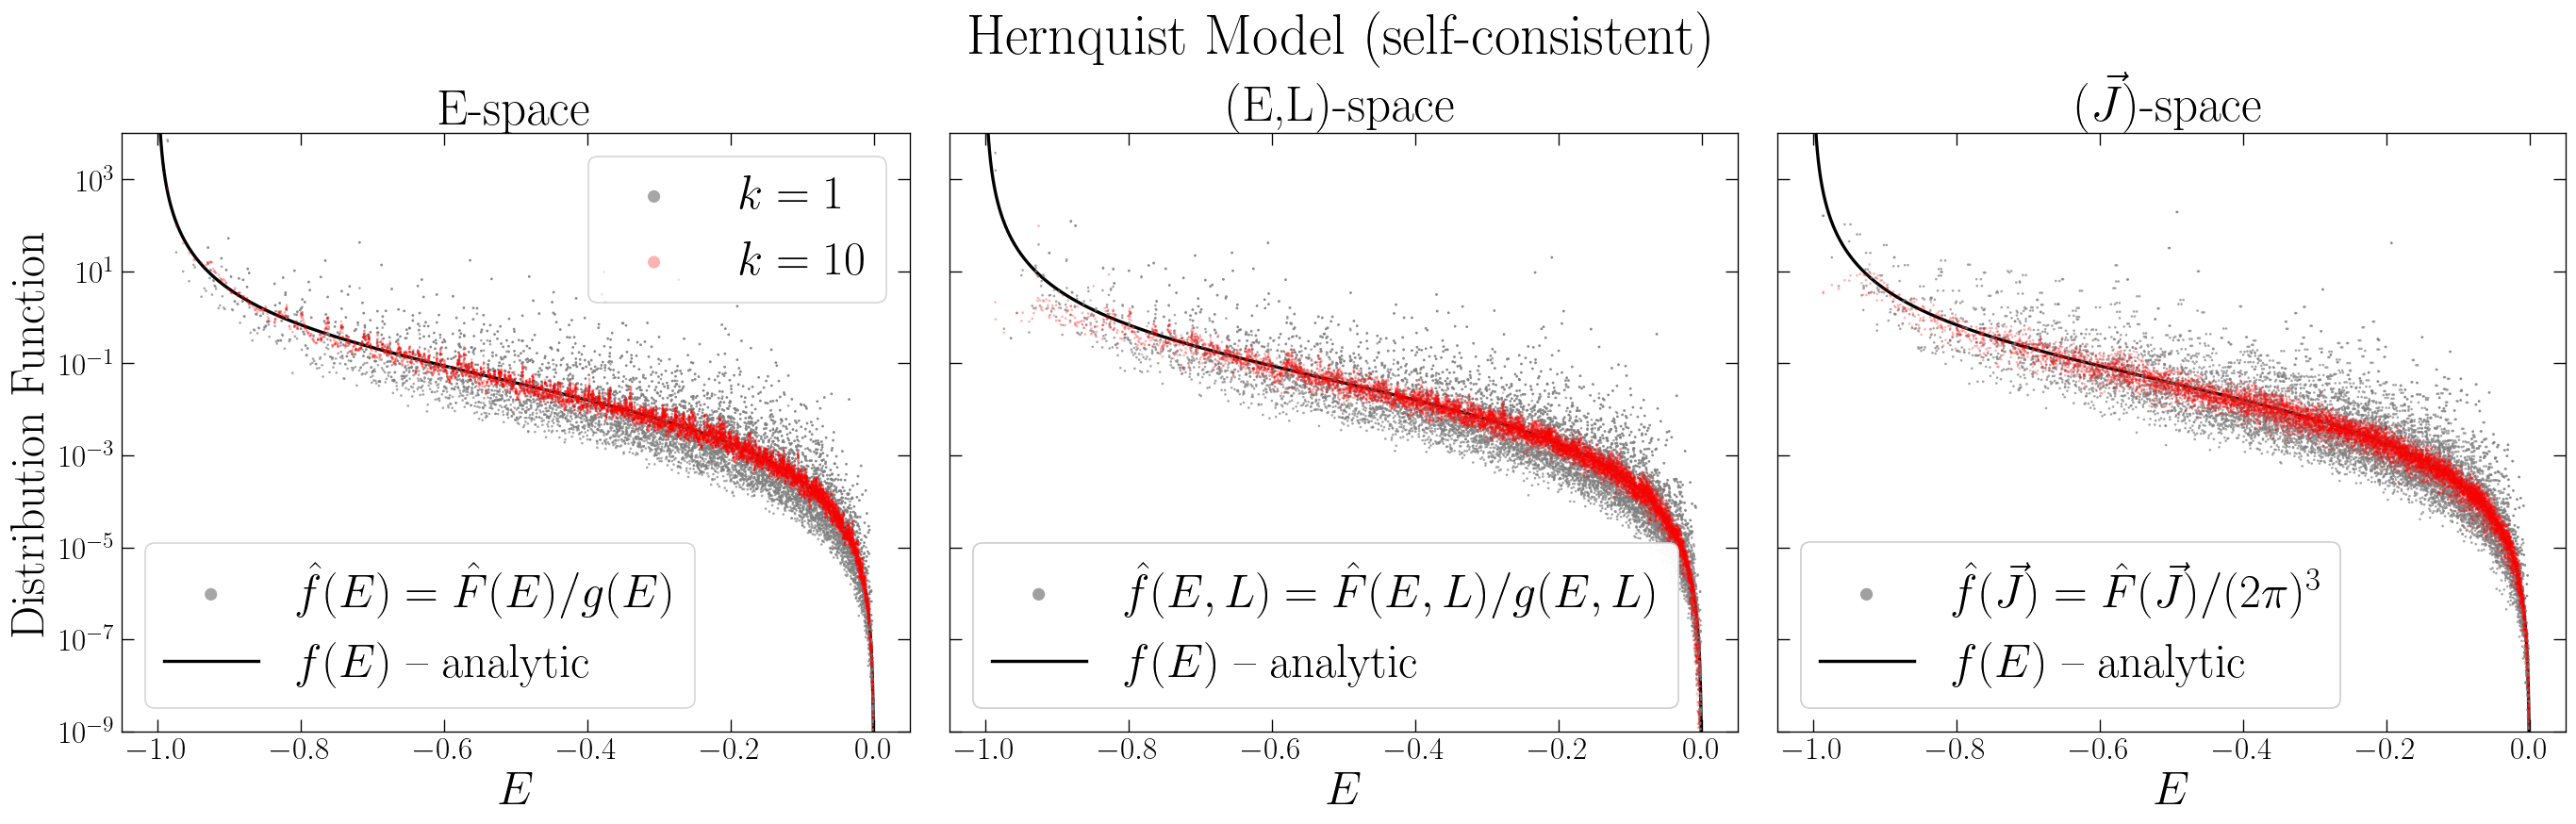

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(24, 7))
fig.patch.set_facecolor('white')
fig.suptitle('Hernquist Model (self-consistent)', fontsize=36)

titles = ['E-space', '(E,L)-space', r'$(\vec{J})$-space']
ylabels = ['Distribution Function', None, None]
ylabels_pos = [True, False, False]

# Data for scatter plots
scatter_data = [(E, f_E_hat_k1, r'$\hat{f}(E) = \hat{F}(E)/g(E)$'),
                (E, f_EL_hat_k1, r'$\hat{f}(E,L) = \hat{F}(E,L)/g(E,L)$'),
                (E, f_J_hat_k1, r'$\hat{f}(\vec{J}) = \hat{F}(\vec{J})/(2\pi)^3$')
]
scatter_red_data = [(E, f_E_hat_k10), 
                    (E, f_EL_hat_k10), 
                    (E, f_J_hat_k10)]
# Create subplots
for i, ax in enumerate(axs):
    ax.set_title(titles[i])
    
    # Scatter grey (k=1)
    sc_grey = ax.scatter(*scatter_data[i][:2], s=10, marker='.', facecolor='grey',
                         edgecolor='none', alpha=0.7, label=scatter_data[i][2])
    # Scatter red (k=10)
    sc_red = ax.scatter(*scatter_red_data[i], s=10, marker='.', facecolor='red',
                        edgecolor='none', alpha=0.3, label=r'$k=10$')
    # Analytic curve
    line_analytic, = ax.plot(bins_E, f_E_true, 'k-', lw=2, zorder=0, label=r'$f(E)$ -- analytic')
    
    # Axes formatting
    ax.set_yscale('log')
    ax.set_ylim(1e-9, 1e+4)
    ax.set_xlabel(r'$E$', fontsize=30)
    if ylabels_pos[i]:
        ax.set_ylabel(ylabels[i], fontsize=30)
    else:
        ax.tick_params(labelleft=False)
    
    # First legend:
    legend1 = ax.legend(handles=[sc_grey, line_analytic], fontsize=30, markerscale=5)
    ax.add_artist(legend1)
    
# Second legend:
legend2 = axs[0].legend(handles=[sc_grey, sc_red], labels=[r'$k=1$', r'$k=10$'],
                    fontsize=30, markerscale=5, loc='upper right')

fig.subplots_adjust(left=0.05, right=0.95, top=0.825, bottom=0.07, wspace=0.05)

We see that the DF is well estimated in these low dimensional spaces of integrals of motion.

Increasing the kth neighbor used in the estimate (red) substancially decreases the scatter.

Below we plot the DF estimates  in 6D.

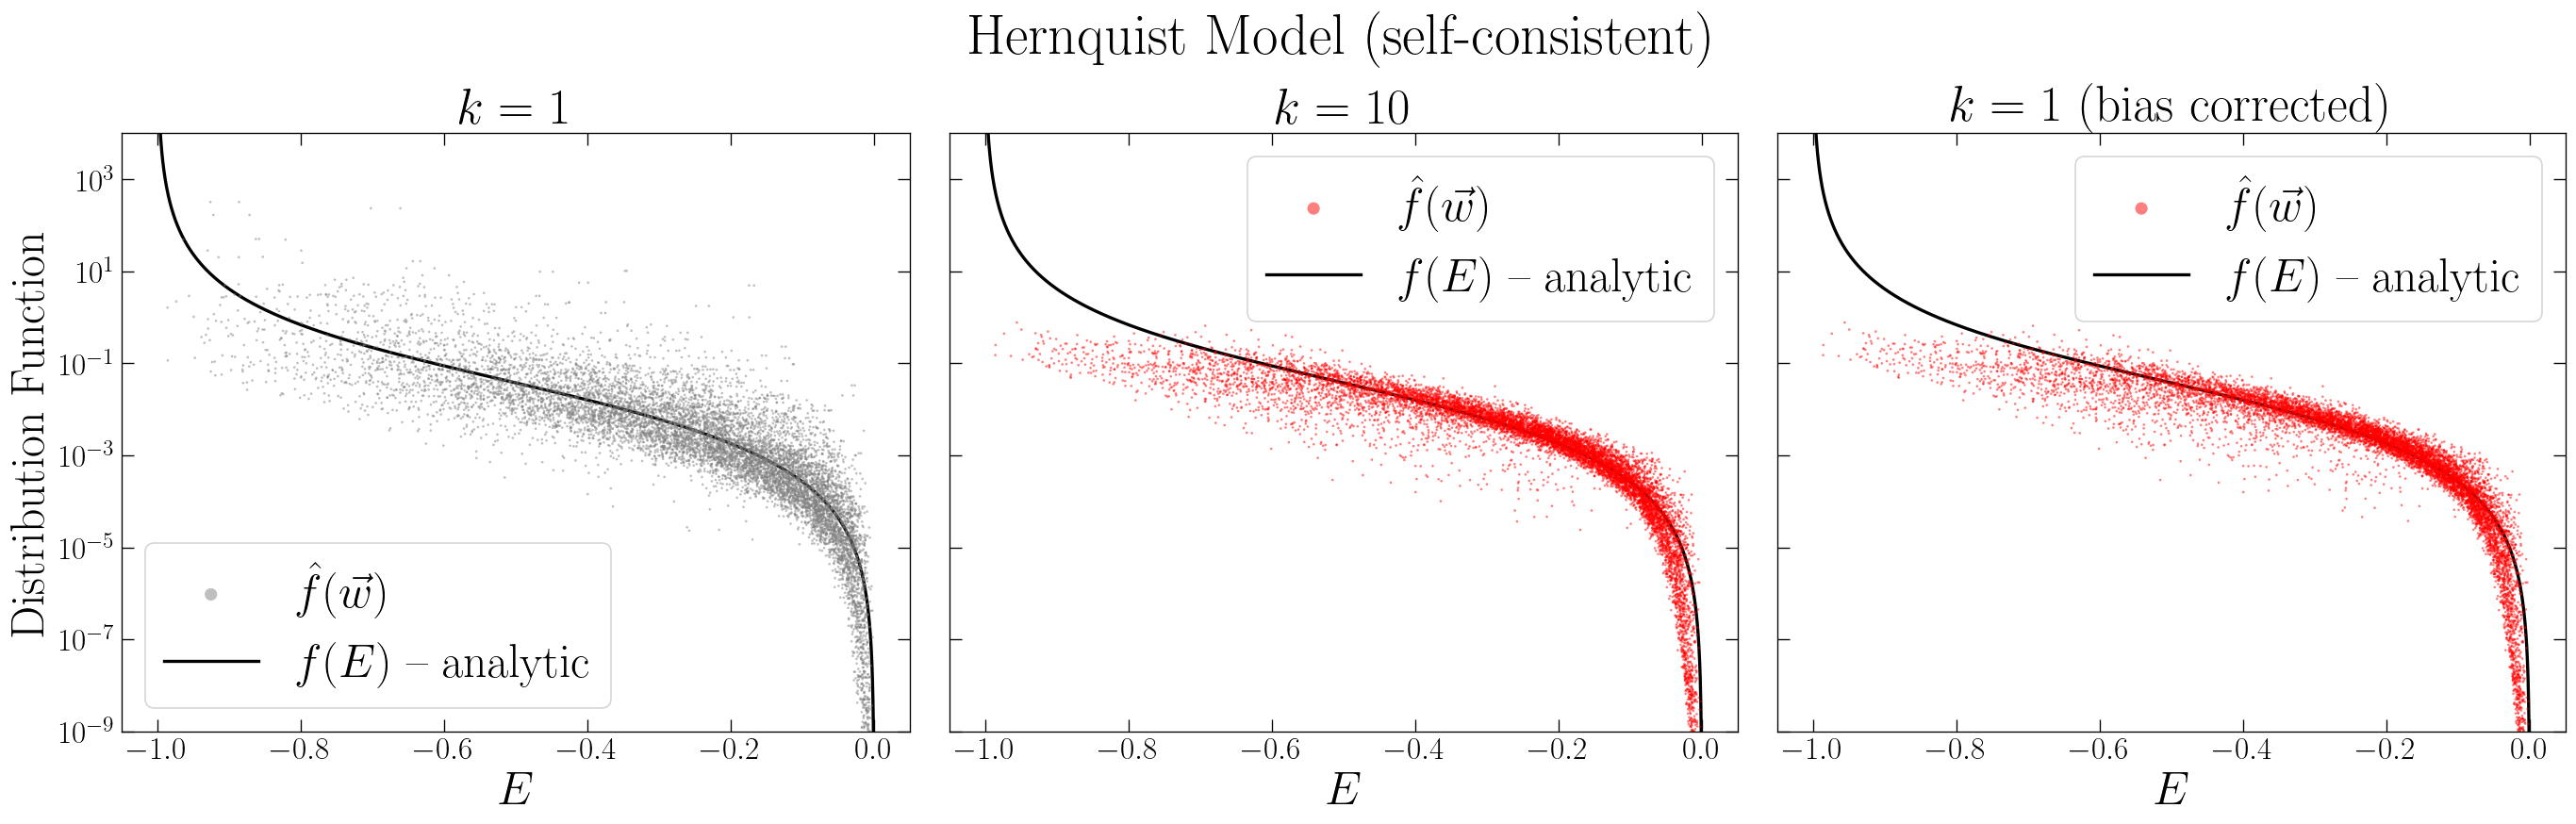

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(24, 7))
fig.patch.set_facecolor('white')
fig.suptitle('Hernquist Model (self-consistent)', fontsize=36)

titles = [r'$k=1$', r'$k=10$', r'$k=1$ (bias corrected)']
ylabels = ['Distribution Function', None, None]
ylabels_pos = [True, False, False]
colors = ['grey', 'red', 'red']

# Data for scatter plots
scatter_data = [(E, f_6D_hat_k1, r'$\hat{f}(\vec{w})$'),
                (E, f_6D_hat_k10, r'$\hat{f}(\vec{w})$'),
                (E, f_6D_hat_k10_correc, r'$\hat{f}(\vec{w})$')
]

# Create subplots
for i, ax in enumerate(axs):
    ax.set_title(titles[i])
    
    # Scatter grey (k=1)
    sc_grey = ax.scatter(*scatter_data[i][:2], s=10, marker='.', facecolor=colors[i],
                         edgecolor='none', alpha=0.5, label=scatter_data[i][2])
    # Analytic curve
    line_analytic, = ax.plot(bins_E, f_E_true, 'k-', lw=2, zorder=0, label=r'$f(E)$ -- analytic')
    
    # Axes formatting
    ax.set_yscale('log')
    ax.set_ylim(1e-9, 1e+4)
    ax.set_xlabel(r'$E$', fontsize=30)
    if ylabels_pos[i]:
        ax.set_ylabel(ylabels[i], fontsize=30)
    else:
        ax.tick_params(labelleft=False)
    
    legend1 = ax.legend(handles=[sc_grey, line_analytic], fontsize=30, markerscale=5)

fig.subplots_adjust(left=0.05, right=0.95, top=0.825, bottom=0.07, wspace=0.05)

Overall we still have reasonable DF estimates, with increasing k decrasing the scatter. But for a fixed number of sampling points, in a higher dimensional space it is harder to estimate the density, in comparison to the estimates in lower dimensions made before. The bias correction slightly improves the estimates for points at the high-energy (low-DF) tail.

## Estimate entropy

Note that, while above we were showing the DF $f$, below we will compare estimates of the entropy of the DF of the normalized coordinates, i.e. the entropy of $f' = |\Sigma_0|f$, where $|\Sigma_0|$ is the product of the initial dispersions of the 6d coordinates.

In [9]:
# Set params and initialize arrays:
kNN = 1 # which Nearest Neighbor

Tcirc = np.full(len(n_orbs), np.nan) # mean circular period for each sample
t = np.full((len(n_orbs), n_steps), np.nan) # time in the orbit integration

S_E_true = np.full(len(n_orbs), np.nan)
S_6D = np.full((len(n_orbs), n_steps), np.nan) # Entropy evaluated in 6D

# Entropies assuming the DF is f = f(E), or f = f(E,L), or f = f(J)
# These should be the same as S_6D if f = f(E), or f = f(E,L), or f = f(J)
S_E = np.full(len(n_orbs), np.nan)
S_EL = np.full(len(n_orbs), np.nan)
S_J = np.full(len(n_orbs), np.nan)

In [10]:
# Generate samples, integrate and estimate entropy:
for i in range(len(n_orbs)):
    print ('-------------------------')
    dim = 6
    print ('Generating sample...')
    N = n_orbs[i]
    # Generate self-consistent sample of the Hernquist potential.
    # Some care is needed here, since it's important to make sure the initial sample is really stationary in the potential.
    # A constant entropy for this sample indicates that it is truly stationary - see plot below with the time evolution.
    # If using agama, see option #define DISABLE_QRNG in src/math_sample.cpp, or in Makefile.local, which might need to be set before compilation
    data,_ = agama.GalaxyModel(hern_pot, hern_df).sample(N)
    # data, _ = hern_pot.sample(N, potential=hern_pot) 
    #------------------------------ 
    sigma_6D_0 = np.array([0.5*(np.percentile(coord, 84) - np.percentile(coord, 16)) for coord in data.T])
    mu_0 = 1./np.prod(sigma_6D_0)

    # In principle, S_true shouldn't depend on the sample size, and could be calculated outside of this loop,
    # But we are using mu = |Sigma|^(-1) to normalize the coordinates, with the exact |Sigma| changing for different samples,
    # but |Sigma| converges for large samples
    S_E_true[i] = -integrate.quad(S_E_true_integrand, a=E_I_min, b=E_I_max, args=(M, b, mu_0, G))[0]
    print ('S_E (true):', np.round(S_E_true[i], 5))
    #------------------------------ 
    # Estimate S_6D (at t=0; estimates over time are done below):

    S_6D[i, 0] = tropygal.entropy(data/sigma_6D_0)
    print ('S_6D estimated:', np.round(S_6D[i, 0], 5))
    #------------------
    # Estimate S_E, i.e. assuming f = f(E):
    
    x  = data[:,0]; y  = data[:,1]; z  = data[:,2]
    vx = data[:,3]; vy = data[:,4]; vz = data[:,5]
    
    v2 = vx**2 + vy**2 + vz**2
    pos = np.column_stack((x, y, z))
    E = hern_pot.potential(pos) + 0.5*v2
    sigma_E = 0.5*(np.percentile(E, 84) - np.percentile(E, 16))
    
    g_E = tropygal.g_Hernquist(E, M, b=b, G=G)
    # It's convenient to normalize coordinates in the space where the entropy is estimated,
    # but we want to stick to the entropy definition we used before, so the normalized coordinates are passed as the data,
    # and mu takes care of the appropriate factors in the change of variables for the integral defining the entropy to be the same.
    S_E[i] = tropygal.entropy(E/sigma_E, mu= g_E*sigma_E*mu_0)
    print ('S_E estimated:', np.round(S_E[i], 5))
    #-------------------------
    # Estimate S_EL, i.e. assuming f = f(E,L):
    
    Lx = (y*vz - z*vy)
    Ly = (z*vx - x*vz)
    Lz = (x*vy - y*vx)
    L = np.sqrt(Lx**2 + Ly**2 + Lz**2)
    EL = np.column_stack((E, L))
    sigma_L = 0.5*(np.percentile(L, 84) - np.percentile(L, 16))
    sigma_EL = np.array([sigma_E, sigma_L])

    g_EL = tropygal.gEL_Spherical(E, L, tropygal.Phi_Hernquist, tropygal.dPhi_dr_Hernquist, params)
    S_EL[i] = tropygal.entropy(EL/sigma_EL, mu= g_EL*np.prod(sigma_EL)*mu_0)
    print ('S_EL estimated:', np.round(S_EL[i], 5))
    #------------------------------ 
    # Estimate S_J, i.e. assuming f = f(J):

    J = actF(data, actions=True, frequencies=False, angles=False)
    sigma_J = np.array([0.5*(np.percentile(coord, 84) - np.percentile(coord, 16)) for coord in J.T])
    S_J[i] = tropygal.entropy(J/sigma_J, mu= ((2.*np.pi)**3)*np.prod(sigma_J)*mu_0)
    print ('S_J estimated:', np.round(S_J[i],5))
    #------------------------------ 
    # Estimate S_6D at different times

    # define integration time (same for all orbits):
    Tcirc[i] = np.median(hern_pot.Tcirc(data))
    int_time = 50*Tcirc[i]
    delta_t = int_time/n_steps

    # Integrate orbits for the entire time interval, storing the outputs at regular timesteps:
    orbs = agama.orbit(potential=hern_pot, ic=data, time=int_time, trajsize=n_steps, method='dop853', accuracy=1e-6, verbose=False)
    # Other orbit integration methods:
    #orbs = agama.orbit(potential=isoc_pot, ic=data, time=int_time, trajsize=n_steps, method='dprkn8', accuracy=1e-6, verbose=False)
    t[i] = orbs[0,0]  # 0th column is the array of times for each orbit (identical for all orbits, so we take the one from the 0th row)
    trajs = np.stack(orbs[:,1])  # 1st column is the array of trajectories, each element is itself a N x 6 array; stack them up.
    for j in range(1, n_steps):
        all_coords = trajs[:,j]
        sigma_6D = np.array([0.5*(np.percentile(coord, 84) - np.percentile(coord, 16)) for coord in all_coords.T])
        # Here we re-normalize again at every time-step (to facilitate the estimate), 
        # "compensating" for that in the mu factor, i.e. making an appropriate change of variables every time-step:
        S_6D[i,j] = tropygal.entropy(all_coords/sigma_6D, mu=np.prod(sigma_6D)*mu_0, k=kNN)
        if (j%10==0):
            print ('j:', j, 'S_6D estimated:', np.round(S_6D[i, j], 5))

-------------------------
Generating sample...
S_E (true): 9.05639
S_6D estimated: 9.53506
S_E estimated: 9.04534


/var/folders/ln/7t1_bznj4l9cj5_59_yk0y640000gt/T/ipykernel_35766/1131633081.py:20: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  S_E_true[i] = -integrate.quad(S_E_true_integrand, a=E_I_min, b=E_I_max, args=(M, b, mu_0, G))[0]


S_EL estimated: 9.0542
S_J estimated: 9.04268
j: 10 S_6D estimated: 9.51472
j: 20 S_6D estimated: 9.50163
j: 30 S_6D estimated: 9.512
j: 40 S_6D estimated: 9.52978
j: 50 S_6D estimated: 9.51881
j: 60 S_6D estimated: 9.5095
j: 70 S_6D estimated: 9.50151
j: 80 S_6D estimated: 9.50615
j: 90 S_6D estimated: 9.5023
-------------------------
Generating sample...
S_E (true): 9.00994
S_6D estimated: 9.33116
S_E estimated: 9.02335
S_EL estimated: 9.03079
S_J estimated: 9.04426
j: 10 S_6D estimated: 9.32689
j: 20 S_6D estimated: 9.32717
j: 30 S_6D estimated: 9.33004
j: 40 S_6D estimated: 9.322
j: 50 S_6D estimated: 9.32535
j: 60 S_6D estimated: 9.32433
j: 70 S_6D estimated: 9.32626
j: 80 S_6D estimated: 9.32994
j: 90 S_6D estimated: 9.33142
-------------------------
Generating sample...
S_E (true): 9.0262
S_6D estimated: 9.22848
S_E estimated: 9.0267
S_EL estimated: 9.03336
S_J estimated: 9.03458
j: 10 S_6D estimated: 9.22969
j: 20 S_6D estimated: 9.23055
j: 30 S_6D estimated: 9.2328
j: 40 S_6D 

In [13]:
# Calc errors
err_S_6D = np.zeros(len(n_orbs))
err_S_E = np.zeros(len(n_orbs))
err_S_EL = np.zeros(len(n_orbs))
err_S_J = np.zeros(len(n_orbs))
#-------------------
for i in range(len(n_orbs)):
    # Calculate error with the time-average of S_6D, in respect to the true value:
    err_S_6D[i] = (np.mean(S_6D[i]) - S_E_true[-1])/S_E_true[-1]
    
    err_S_E[i] = (S_E[i] - S_E_true[-1])/S_E_true[-1]
    err_S_EL[i] = (S_EL[i] - S_E_true[-1])/S_E_true[-1]
    err_S_J[i] = (S_J[i] - S_E_true[-1])/S_E_true[-1]

    print ('N:', n_orbs[i],'S_E_true:', S_E_true[-1], 'err S_J:',(np.mean(S_J[i]) - S_E_true[-1]))

N: 10000 S_E_true: 9.026202078392181 err S_J: 0.01647659657350964
N: 100000 S_E_true: 9.026202078392181 err S_J: 0.018055638518834627
N: 1000000 S_E_true: 9.026202078392181 err S_J: 0.008379659306704923


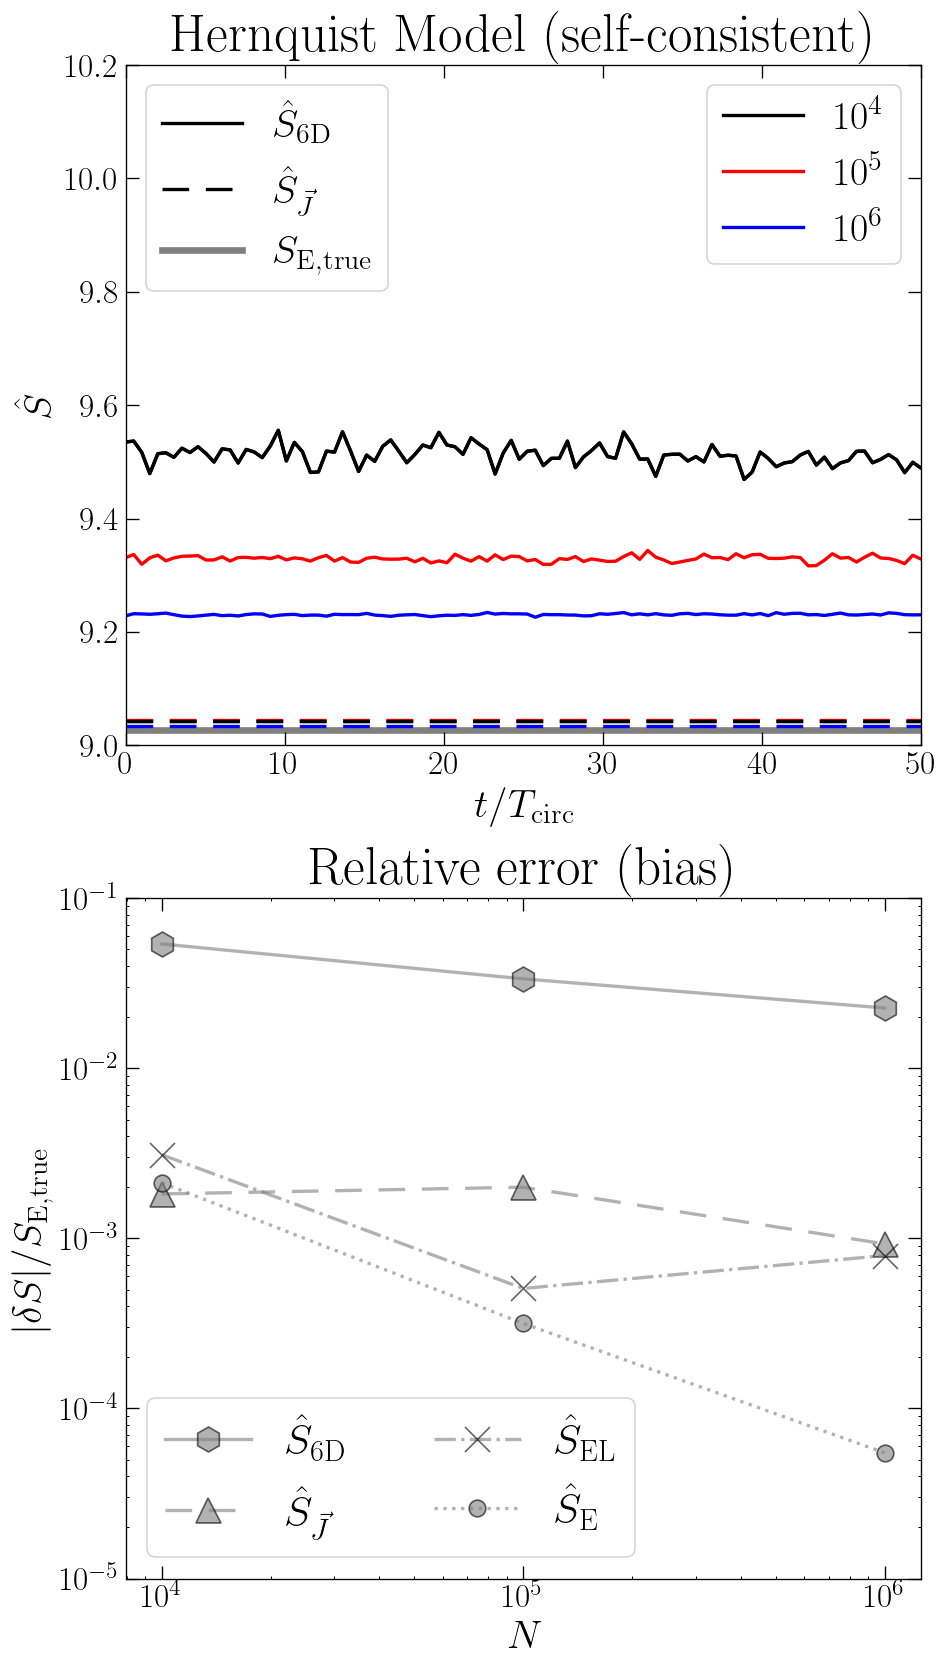

In [14]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(8,14))
fig.patch.set_facecolor('white')

axs[0].set_title('Hernquist Model (self-consistent)')
axs[1].set_title('Relative error (bias)')

ones = np.ones(n_steps)

for i in range(len(n_orbs)):
    axs[0].plot(t[i]/Tcirc[i], S_6D[i], ls='-', lw=2, c=N_colors[i], label=N_label_plot[i]) # Assumption-free estimate
    #axs[0].plot(t[i]/Tcirc[i], S_E[i]*ones, ls='--', dashes=(8,5), lw=2, c=N_colors[i]) # Assuming the DF is an unknown f = f(E)
    #axs[0].plot(t[i]/Tcirc[i], S_EL[i]*ones, ls='--', dashes=(8,5), lw=2, c=N_colors[i]) # Assuming the DF is an unknown f = f(E,L)
    axs[0].plot(t[i]/Tcirc[i], S_J[i]*ones, ls='--', dashes=(8,5), lw=2, c=N_colors[i]) # Assuming the DF is an unknown f = f(J)

# To have two legends:
l1 = axs[0].legend(fontsize=24)

p1, = axs[0].plot(t[0]/Tcirc[0], S_6D[0], ls='-', lw=2, c=N_colors[0])
p2, = axs[0].plot(t[0]/Tcirc[0], S_J[0]*ones, color=N_colors[0], linestyle='--', dashes=(8,5), lw=2)
p3, = axs[0].plot(t[-1]/Tcirc[-1], S_E_true[-1]*ones, color='grey', linestyle='-', lw=4, zorder=0)
axs[0].legend([p1, p2, p3], [r'$\hat{S}_\mathrm{6D}$', r'$\hat{S}_{\vec{J}}$', r'$S_{\mathrm{E, true}}$'],
              loc='upper left', fontsize=24)
# Add l1 as a separate artist to the axes
axs[0].add_artist(l1)
#----------------
axs[1].plot(n_orbs, np.abs(err_S_6D),'h-',c='grey', ms=15, lw=2, mec='black', alpha=0.6, label=r'$\hat{S}_\mathrm{6D}$')
axs[1].plot(n_orbs, np.abs(err_S_J), '^--', c='grey', ms=15, dashes=(8,5), lw=2, mec='black', alpha=0.6, label=r'$\hat{S}_{\vec{J}}$')
axs[1].plot(n_orbs, np.abs(err_S_EL), 'x-.', c='grey', ms=15, lw=2, mec='black', alpha=0.6, label=r'$\hat{S}_\mathrm{EL}$')
axs[1].plot(n_orbs, np.abs(err_S_E), '.:', c='grey', ms=20, lw=2, mec='black', alpha=0.6, label=r'$\hat{S}_\mathrm{E}$')

axs[1].legend(fontsize=26, loc='lower left', ncol=2)
#---------------------
axs[0].set_xlabel(r'$t/T_\mathrm{circ}$')
axs[0].set_ylabel(r'$\hat{S}$')
axs[0].set_ylim(9.,10.2)
axs[0].set_xlim(0, 50)
    
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[1].set_xlabel(r'$N$')
axs[1].set_ylim(1e-5,1e-1)
axs[1].set_ylabel(r'$|\delta S|/S_{\mathrm{E, true}}$')

plt.tight_layout()

## Evolve initial sample in new potential

In [15]:
M_new = 3. # mass of new potential (where we integrate orbits for a non-stationary sample)
params = np.array([M_new, b, G])

In [16]:
# Set params and initialize arrays:

Tcirc_new = np.full(len(n_orbs), np.nan) # mean circular period for each sample
t_new = np.full((len(n_orbs), n_steps), np.nan) # time in the orbit integration
S_6D_new = np.full((len(n_orbs), n_steps), np.nan) # Entropy evaluated in 6D

# Entropies assuming the DF is f = f(E,L), or f = f(J) - now only expected to be valid after the system phase-mixes
# These should be the same as S_6D if f = f(E,L), or f = f(J). In the current case, this happens at the late times only.

S_EL_new = np.full(len(n_orbs), np.nan)
S_J_new = np.full(len(n_orbs), np.nan)

# new Potential:
hern_pot_new = agama.Potential(type='Dehnen', mass=M_new, scaleRadius=b, gamma=1)
# Action finder in the new potential:
actF_new = agama.ActionFinder(hern_pot_new)

In [17]:
# Same as before, but generating sample stationary in the potential with mass M=1, and evolving it in a potential with mass M=3.
# Generate samples, integrate and estimate entropy:
for i in range(len(n_orbs)):
    print ('-------------------------')
    dim = 6
    print ('Generating sample...')
    N = n_orbs[i]
    data,_ = agama.GalaxyModel(hern_pot, hern_df).sample(N)
    # data, _ = hern_pot.sample(N, potential=hern_pot) 
    sigma_6D_0 = np.array([0.5*(np.percentile(coord, 84) - np.percentile(coord, 16)) for coord in data.T])
    #------------------------------ 
    # Estimate S_6D (at t=0; estimates over time are done below):

    S_6D_new[i, 0] = tropygal.entropy(data/sigma_6D_0)
    print ('S_6D estimated:', np.round(S_6D_new[i, 0], 5))
    #------------------
    # Estimate S_EL, i.e. assuming f = f(E,L):

    x  = data[:,0]; y  = data[:,1]; z  = data[:,2]
    vx = data[:,3]; vy = data[:,4]; vz = data[:,5]
    
    v2 = vx**2 + vy**2 + vz**2
    pos = np.column_stack((x, y, z))
    E = hern_pot_new.potential(pos) + 0.5*v2
    sigma_E = 0.5*(np.percentile(E, 84) - np.percentile(E, 16))
    
    Lx = (y*vz - z*vy)
    Ly = (z*vx - x*vz)
    Lz = (x*vy - y*vx)
    L = np.sqrt(Lx**2 + Ly**2 + Lz**2)
    EL = np.column_stack((E, L))
    sigma_L = 0.5*(np.percentile(L, 84) - np.percentile(L, 16))
    sigma_EL = np.array([sigma_E, sigma_L])

    g_EL = tropygal.gEL_Spherical(E, L, tropygal.Phi_Hernquist, tropygal.dPhi_dr_Hernquist, params)
    # It's convenient to normalize coordinates in the space where the entropy is estimated,
    # but we want to stick to the entropy definition we used before, so the normalized coordinates are passed as the data,
    # and mu takes care of the appropriate factors in the change of variables for the integral defining the entropy to be the same:
    S_EL_new[i] = tropygal.entropy(EL/sigma_EL, mu= g_EL*np.prod(sigma_EL)/np.prod(sigma_6D_0))
    print ('S_EL estimated:', np.round(S_EL_new[i], 5))
    #------------------------------ 
    # Estimate S_J, i.e. assuming f = f(J):

    J = actF_new(data, actions=True, frequencies=False, angles=False)
    sigma_J = np.array([0.5*(np.percentile(coord, 84) - np.percentile(coord, 16)) for coord in J.T])

    S_J_new[i] = tropygal.entropy(J/sigma_J, mu= ((2.*np.pi)**3)*np.prod(sigma_J)/np.prod(sigma_6D_0))
    print ('S_J estimated:', np.round(S_J_new[i],5))
    #------------------------------ 
    # Estimate S_6D at different times

    # define integration time (same for all orbits):
    Tcirc_new[i] = np.median(hern_pot_new.Tcirc(data))
    int_time = 50*Tcirc_new[i]
    delta_t = int_time/n_steps

    orbs = agama.orbit(potential=hern_pot_new, ic=data, time=int_time, trajsize=n_steps, method='dop853', accuracy=1e-6, verbose=False)
    # Other orbit integration methods:
    #orbs = agama.orbit(potential=isoc_pot_new, ic=data, time=int_time, trajsize=n_steps, method='dprkn8', accuracy=1e-6, verbose=False)
    t_new[i] = orbs[0,0]
    trajs = np.stack(orbs[:,1])
    for j in range(1, n_steps):
        all_coords = trajs[:,j]

        sigma_6D = np.array([0.5*(np.percentile(coord, 84) - np.percentile(coord, 16)) for coord in all_coords.T])
        # Here we re-normalize again at every time-step (to facilitate the estimate), 
        # "compensating" for that in the mu factor, i.e. making an appropriate change of variables every time-step:
        S_6D_new[i,j] = tropygal.entropy(all_coords/sigma_6D, mu=np.prod(sigma_6D)*mu_0)
        if (j%10==0):
            print ('j:', j, 'S_6D estimated:', np.round(S_6D_new[i, j], 5))

-------------------------
Generating sample...
S_6D estimated: 9.46986
S_EL estimated: 9.57783
S_J estimated: 9.59651
j: 10 S_6D estimated: 10.15345
j: 20 S_6D estimated: 10.12496
j: 30 S_6D estimated: 10.1333
j: 40 S_6D estimated: 10.15331
j: 50 S_6D estimated: 10.12406
j: 60 S_6D estimated: 10.13404
j: 70 S_6D estimated: 10.14078
j: 80 S_6D estimated: 10.1327
j: 90 S_6D estimated: 10.18323
-------------------------
Generating sample...
S_6D estimated: 9.32196
S_EL estimated: 9.61109
S_J estimated: 9.6143
j: 10 S_6D estimated: 9.96392
j: 20 S_6D estimated: 9.97411
j: 30 S_6D estimated: 9.96675
j: 40 S_6D estimated: 9.95841
j: 50 S_6D estimated: 9.95922
j: 60 S_6D estimated: 9.95136
j: 70 S_6D estimated: 9.94129
j: 80 S_6D estimated: 9.9594
j: 90 S_6D estimated: 9.94363
-------------------------
Generating sample...
S_6D estimated: 9.23339
S_EL estimated: 9.60966
S_J estimated: 9.61532
j: 10 S_6D estimated: 9.78898
j: 20 S_6D estimated: 9.83396
j: 30 S_6D estimated: 9.84308
j: 40 S_6D 

## Plot

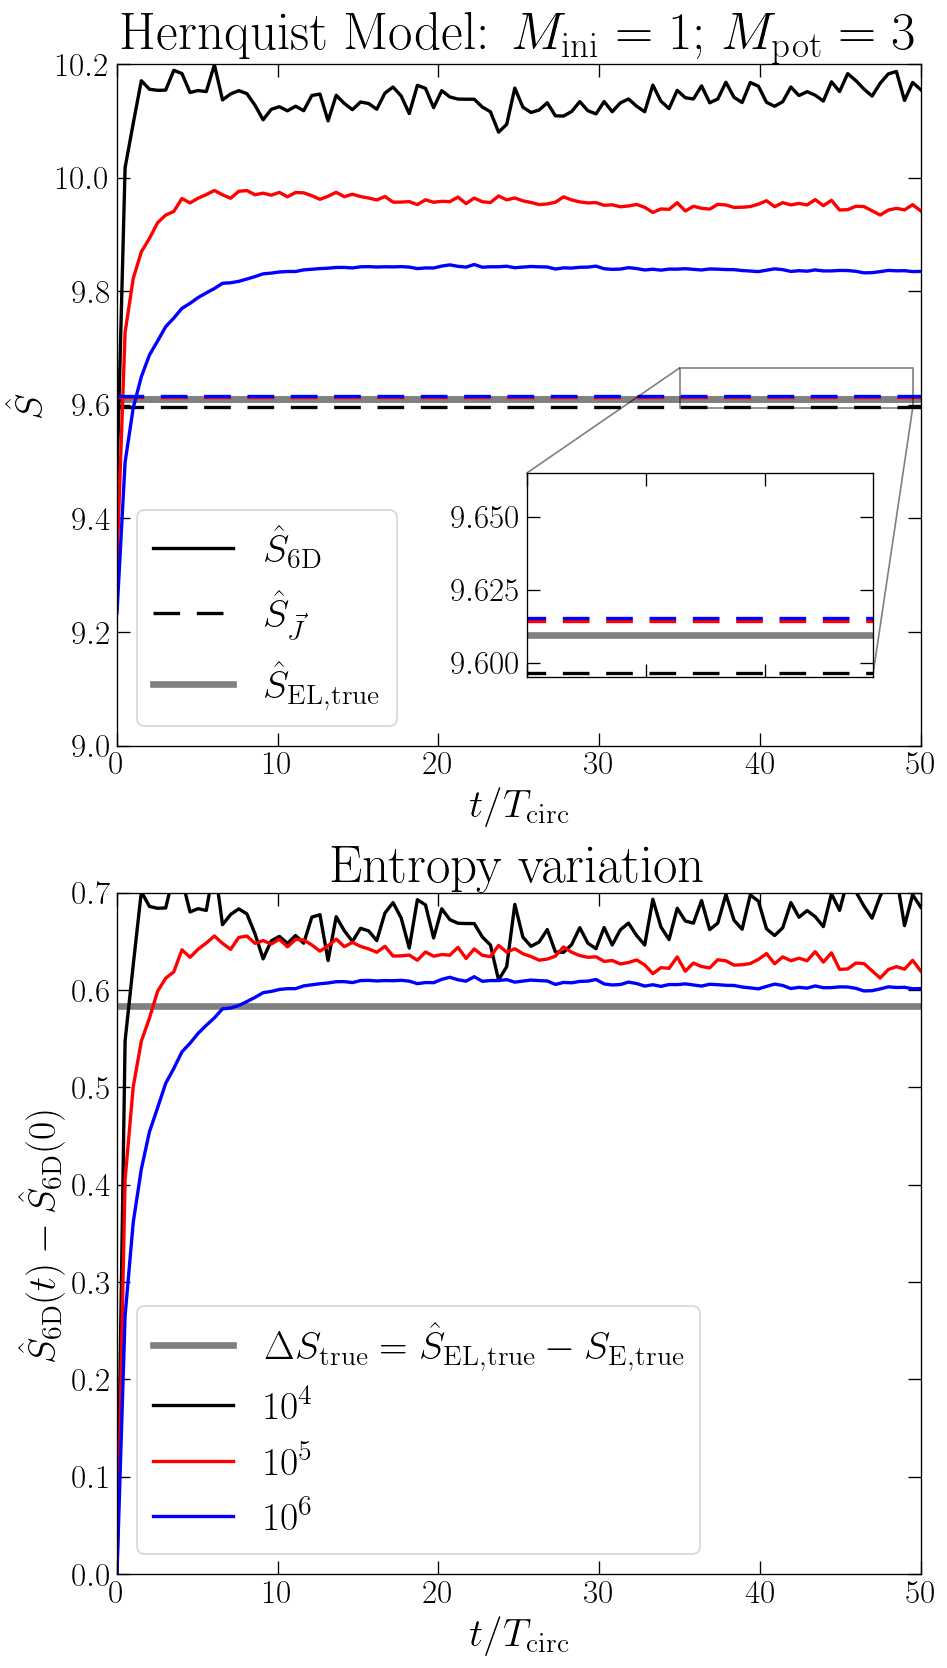

In [18]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(8,14))
fig.patch.set_facecolor('white')
axs[0].set_title(r'Hernquist Model: $M_\mathrm{ini}=1$; $M_\mathrm{pot}=3$')
axs[1].set_title('Entropy variation')

ones = np.ones(n_steps)
axs[0].axhline(y=S_EL_new[-1], color='grey', linestyle='-', lw=4, zorder=0)#, label=r'$S_{EL}$')

for i in range(len(n_orbs)):
    axs[0].plot(t_new[i]/Tcirc_new[i], S_6D_new[i], ls='-', lw=2, c=N_colors[i])
    axs[0].plot(t_new[i]/Tcirc_new[i], S_J_new[i]*ones, ls='--', dashes=(8,5), lw=2, c=N_colors[i])

p4, = axs[0].plot(t_new[-1]/Tcirc_new[-1], S_EL_new[-1]*ones, color='grey', ls='-', lw=4, zorder=0)

axs[0].legend([p1, p2, p4], [r'$\hat{S}_\mathrm{6D}$', r'$\hat{S}_{\vec{J}}$', r'$\hat{S}_{\mathrm{EL, true}}$'], 
              loc = 'lower left', fontsize=24)
#---------------------
# inset axes:
x1, x2, y1, y2 = 35, 49.5, 9.595, 9.665  # subregion of the original image
axins = axs[0].inset_axes([0.51, 0.1, 0.43, 0.3],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[])#, yticklabels=[])
axins.axhline(y=S_EL_new[-1], color='grey', linestyle='-', lw=4, zorder=0)
for i in range(len(n_orbs)):
    axins.plot(t_new[i]/Tcirc_new[i], S_J_new[i]*ones, ls='--', dashes=(8,5), lw=2, c=N_colors[i])

axs[0].indicate_inset_zoom(axins, edgecolor="black")
#---------------------
# We take the final S_EL (estimated with the largest sample) as the true final S_EL:
axs[1].axhline(y=S_EL_new[-1] - S_E_true[-1], 
               color='grey', linestyle='-', lw=4, label=r'$\Delta S_\mathrm{true} = \hat{S}_{\mathrm{EL, true}} - S_{\mathrm{E, true}}$')

for i in range(len(n_orbs)):
    axs[1].plot(t_new[i]/Tcirc_new[i], S_6D_new[i]-S_6D_new[i, 0], ls='-', lw=2, c=N_colors[i], label=N_label_plot[i]) # Plotting Delta S

axs[0].set_ylabel(r'$\hat{S}$')
axs[0].set_ylim(9.0, 10.2)
axs[1].set_ylabel(r'$\hat{S}_\mathrm{6D}(t) - \hat{S}_\mathrm{6D}(0)$')
axs[1].set_ylim(0, 0.7)
axs[1].legend(fontsize=24)

for i in range(2):
    axs[i].set_xlim(0, 50)
    axs[i].set_xlabel(r'$t/T_\mathrm{circ}$')

plt.tight_layout()